# 飞桨常规赛：PALM眼底彩照中黄斑中央凹定位

## 0. 赛题介绍
常规赛：PALM眼底彩照中黄斑中央凹定位由ISBI2019 PALM眼科挑战赛赛题再现，其中黄斑中央凹定位的任务旨在对眼科图像进行判断是否存在黄斑中央凹，并对其进行定位。

数据集由中山大学中山眼科中心提供800张带黄斑中央凹坐标标注的眼底彩照供选手训练模型，另提供400张带标注数据供平台进行模型测试。图像分辨率为1444×1444，或2124×2056。黄斑中央凹坐标信息存储在xlsx文件中，名为“Fovea_Location_train”，第一列对应眼底图像的文件名(包括扩展名“.jpg”)，第二列包含x坐标，第三列包含y坐标。

评价指标为平均欧式距离，计算每个测试样本预测的黄斑中央凹坐标与金标准的差距，最终计算平均的欧式距离。 最终评分为平均欧式距离的倒数。

![](https://ai-studio-static-online.cdn.bcebos.com/d229312f2d244037b5ec3cce55da977ec4589408156b4947b49802373371bf2b)

比赛链接: [常规赛：PALM眼底彩照中黄斑中央凹定位](https://aistudio.baidu.com/aistudio/competition/detail/86)

## 1. 包准备
用resnet50加载一个训练更多的预训练模型。

In [1]:
import os
import pandas as pd
import numpy as np
import paddle
import paddle.vision.transforms as T
from paddle.io import Dataset
from PIL import Image

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


## 2. 数据准备
### 2.1解压数据集

In [2]:
! unzip -oq data/data100179/常规赛：PALM眼底彩照中黄斑中央凹定位.zip
! rm -rf __MACOSX
! mv 常规赛：PALM眼底彩照中黄斑中央凹定位 PLAM

### 2.2 配置数据集
1. 因为数据中本身就有了这个图像名和标签，我们就不用生成数据列表了。直接继承io中的Dataset，用于读取数据。因为与开始说数据的大小有两种分辨率为1444×1444，或2124×2056。这里都放到了1440+360=1800，基本上取二者之间吧。
2. 划分的比列为0.85，图像增强只有简单的色彩和水平翻转。
3. 这里主要注意当图像大小发生了变化，对应的中央凹的坐标也需要进行相应的变化。数据增广就没有写几何变换有关的了，因为这样就要自己写一下对应增强。
4. 最开始数据我还加上了是否存在的类别标签，但是后期效果不明显，可能是自己的原因，这里给注释了，大佬们觉得有道理也可是试试。
### 2.3 数据说明
![](https://ai-studio-static-online.cdn.bcebos.com/e1f6b8af16f049efa1bc41b998a142ed3615caba96fe4de491400cb39998f617)


In [3]:
import warnings
warnings.filterwarnings("ignore") #拒绝烦人的警告信息

In [4]:
from paddle.io import DataLoader

tpsize = 256 
split = 0.9
batch_size = 16

class PLAMDatas(Dataset):
    def __init__(self, data_path, class_xls, mode='train', transforms=None, re_size=tpsize):
        super(PLAMDatas, self).__init__()
        self.data_path = data_path
        self.name_label = (pd.read_excel(class_xls)).values
        lens = len(self.name_label)
        if mode == 'train':
            self.name_label = self.name_label[:int(split*lens)]
        else:
            self.name_label = self.name_label[int(split*lens):]
        self.transforms = transforms
        self.re_size = re_size
        
    def __getitem__(self, index):
        name, x, y = self.name_label[index] # 得到的数据赋值一下
        data_path = os.path.join(self.data_path, name) # 文件系统路径+图片的name=图片的路径
        data = np.asarray(Image.open(data_path).convert('RGB'))
        H, W, _ = data.shape
        if self.transforms is not None:
            data = self.transforms(data)
        data = data.astype('float32')
        
        label = np.array([x * self.re_size / W, y * self.re_size / H]).astype('float32') # 图片大小变了，对应的坐标自然也要改变
        return data, label
        
    def __len__(self):
        return len(self.name_label)

# 配置数据增广
train_transforms = T.Compose([
    T.Resize((tpsize, tpsize), interpolation='bicubic'), #都调整到1800 选用bicubic，放大不至于太失真
   	T.ToTensor()
])

val_transforms = T.Compose([
    T.Resize((tpsize, tpsize), interpolation='bicubic'),
    T.ToTensor()
])

# 配置数据集
train_dataset = PLAMDatas(data_path='PLAM/Train/fundus_image', class_xls='PLAM/Train/Fovea_Location_train.xlsx', mode='train', transforms=train_transforms)
val_dataset = PLAMDatas(data_path='PLAM/Train/fundus_image', class_xls='PLAM/Train/Fovea_Location_train.xlsx', mode='test', transforms=val_transforms)

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=batch_size,
                              shuffle=True, drop_last=False)
dev_dataloader = DataLoader( dataset=val_dataset, 
                             batch_size=batch_size,
                             shuffle=True, drop_last=False)

这里也可以输出测试一下，看看数据读取有没有什么问题。避免后面报一堆错不知道哪儿去找问题。顺便看看点是不是点到位了。

In [5]:
print(len(train_dataset), len(val_dataset))
print(len(train_dataloader), len(dev_dataloader))

720 80
45 5


## 3. 模型训练
### 3.1 模型准备

In [6]:
import paddle
import paddle.nn as nn
from paddle.vision.models import resnet50

# 模型定义
# pre_params = paddle.load('resnet_50_save_models/final.pdparams')
# model.set_state_dict(pre_params)
model = nn.Sequential(
    resnet50(pretrained=True),
    nn.LeakyReLU(),
    nn.Linear(1000, 2)  # 坐标定位
)
paddle.summary(model, (1, 3, tpsize, tpsize))
model = paddle.Model(model)

2021-08-14 01:16:03,678 - INFO - unique_endpoints {''}
2021-08-14 01:16:03,680 - INFO - Downloading resnet50.pdparams from https://paddle-hapi.bj.bcebos.com/models/resnet50.pdparams
100%|██████████| 151272/151272 [00:02<00:00, 65060.64it/s]
2021-08-14 01:16:06,174 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams md5 checking...


-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1        [[1, 3, 256, 256]]   [1, 64, 128, 128]        9,408     
   BatchNorm2D-1    [[1, 64, 128, 128]]   [1, 64, 128, 128]         256      
      ReLU-1        [[1, 64, 128, 128]]   [1, 64, 128, 128]          0       
    MaxPool2D-1     [[1, 64, 128, 128]]    [1, 64, 64, 64]           0       
     Conv2D-3        [[1, 64, 64, 64]]     [1, 64, 64, 64]         4,096     
   BatchNorm2D-3     [[1, 64, 64, 64]]     [1, 64, 64, 64]          256      
      ReLU-2         [[1, 256, 64, 64]]    [1, 256, 64, 64]          0       
     Conv2D-4        [[1, 64, 64, 64]]     [1, 64, 64, 64]        36,864     
   BatchNorm2D-4     [[1, 64, 64, 64]]     [1, 64, 64, 64]          256      
     Conv2D-5        [[1, 64, 64, 64]]     [1, 256, 64, 64]       16,384     
   BatchNorm2D-5     [[1, 256, 64, 64]]    [1, 256, 64, 64]   

```
2021-07-23 14:09:08,122 - INFO - unique_endpoints {''}
2021-07-23 14:09:08,124 - INFO - Downloading resnet50.pdparams from https://paddle-hapi.bj.bcebos.com/models/resnet50.pdparams
100%|██████████| 151272/151272 [00:02<00:00, 61339.97it/s]
2021-07-23 14:09:10,837 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams md5 checking...
-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
===============================================================================
     Conv2D-1        [[1, 3, 256, 256]]   [1, 64, 128, 128]        9,408     
   BatchNorm2D-1    [[1, 64, 128, 128]]   [1, 64, 128, 128]         256      
      ReLU-1        [[1, 64, 128, 128]]   [1, 64, 128, 128]          0       
    MaxPool2D-1     [[1, 64, 128, 128]]    [1, 64, 64, 64]           0       
     Conv2D-3        [[1, 64, 64, 64]]     [1, 64, 64, 64]         4,096     
--------------------------------省略-------------------------------------------
BottleneckBlock-16   [[1, 2048, 8, 8]]     [1, 2048, 8, 8]           0       
AdaptiveAvgPool2D-1  [[1, 2048, 8, 8]]     [1, 2048, 1, 1]           0       
     Linear-1           [[1, 2048]]           [1, 1000]          2,049,000   
     ResNet-1        [[1, 3, 256, 256]]       [1, 1000]              0       
    LeakyReLU-1         [[1, 1000]]           [1, 1000]              0       
     Linear-2           [[1, 1000]]             [1, 2]             2,002     
===============================================================================
Total params: 25,612,154
Trainable params: 25,505,914
Non-trainable params: 106,240
-------------------------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 341.54
Params size (MB): 97.70
Estimated Total Size (MB): 439.99
-------------------------------------------------------------------------------
```

### 3.2 损失设定
这里采用红白黑大佬设计了loss损失函数，计算MSE和欧氏距离加权后的平均损失值

In [7]:
# 自定义损失
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

class FocusBCELoss(nn.Layer):
    '''
        本赛题的任务损失函数
    '''
    def __init__(self, weights=[0.5, 0.5]):
        super(FocusBCELoss, self).__init__()
        self.weights = weights  # 损失权重

    def forward(self, predict, label):
        # MSE均方误差
        mse_loss_x = paddle.nn.functional.mse_loss(predict[:, 0], label[:, 0], reduction='mean')
        mse_loss_y = paddle.nn.functional.mse_loss(predict[:, 1], label[:, 1], reduction='mean')
        mse_loss = 0.5 * mse_loss_x + 0.5 * mse_loss_y

        # 欧氏距离
        distance_loss = paddle.subtract(predict, label)
        distance_loss = paddle.square(distance_loss)
        distance_loss = paddle.sum(distance_loss, axis=-1)
        distance_loss = paddle.sqrt(distance_loss)
        distance_loss = paddle.sum(distance_loss, axis=0) / predict.shape[0]   # predict.shape[0] == batch_size
        
        alpha1, alpha2 = self.weights
        all_loss = alpha1*mse_loss + alpha2*distance_loss

        return all_loss, mse_loss, distance_loss

### 3.3 开始训练
这里采用PolynomialDecay跑

**运行时长: 16小时20分钟53秒401毫秒**

In [15]:
# 模型准备
epochs = 1000

lr = paddle.optimizer.lr.PolynomialDecay(learning_rate=2e-3, decay_steps=int(800*tpsize))
opt = paddle.optimizer.Adam(learning_rate=lr, parameters=model.parameters(), weight_decay=paddle.regularizer.L2Decay(5e-6))
loss  = FocusBCELoss(weights=[0.4, 0.6])   # weights，不同类别的损失权重

model.prepare(
    optimizer = opt, 
    loss = loss
    )
visualdl=paddle.callbacks.VisualDL(log_dir='visual_log')

#在使用GPU机器时，可以将use_gpu变量设置成True
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')


# 模型微调
model.fit(
    train_data=train_dataset, 
    eval_data=val_dataset, 
    batch_size=batch_size, 
    epochs=epochs, 
    eval_freq=10, 
    log_freq=1, 
    save_dir='resnet_50_save_models_256_0.9_16', 
    save_freq=10, 
    verbose=1, 
    drop_last=False, 
    shuffle=True, 
    num_workers=0,
    callbacks=[visualdl]
)

跑完1000轮之后的loss基本上稳定在了0.5-2.5  
```
Epoch 993/1000
step 45/45 [==============================] - loss: 0.7025 0.5066 0.8331 - 1s/step        
Epoch 994/1000
step 45/45 [==============================] - loss: 1.8822 2.1647 1.6938 - 1s/step        
Epoch 995/1000
step 45/45 [==============================] - loss: 2.5339 2.9379 2.2646 - 1s/step         
Epoch 996/1000
step 45/45 [==============================] - loss: 1.3060 1.2016 1.3756 - 1s/step         
Epoch 997/1000
step 45/45 [==============================] - loss: 0.7337 0.4999 0.8896 - 1s/step         
Epoch 998/1000
step 45/45 [==============================] - loss: 1.0640 0.8573 1.2018 - 1s/step        
Epoch 999/1000
step 45/45 [==============================] - loss: 1.3307 1.1557 1.4473 - 1s/step        
Epoch 1000/1000
step 45/45 [==============================] - loss: 0.5870 0.3452 0.7482 - 1s/step
```

**可视化情况如下：**   

![](https://ai-studio-static-online.cdn.bcebos.com/87fb75fed9aa43e39b88a8c072f399bb02b533168f194b878bbc498463750d47)


## 4. 模型预测
预测这里就是因为图像的大小变了，所以预测得到的坐标还需要进行一次计算还原到原来的大小，感觉这也是误差的一个来源。

In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import paddle.vision.transforms as T
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.vision.models import resnet50

save_path = 'Fovea_Localization_Results.csv'
file_path = 'PLAM/PALM-Testing400-Images'
imgs_name = os.listdir(file_path)

model = nn.Sequential(
    resnet50(pretrained=False),
    nn.LeakyReLU(),
    nn.Linear(1000, 2)
)
params = paddle.load('resnet_50_save_models_256_0.9_16/final.pdparams')
model.set_state_dict(params)
model.eval()

inf_transforms = T.Compose([
    T.Resize((tpsize, tpsize), interpolation='bicubic'),
    T.ToTensor()
])

pre_data = []
for img_name in imgs_name:
    data_path = os.path.join(file_path, img_name)
    data = np.asarray(Image.open(data_path).convert('RGB'))
    H, W, _ = data.shape
    data = inf_transforms(data)
    data = data.astype('float32').reshape([1, 3, tpsize, tpsize])
    pred = model(data)
    pre = [None] * 2
    # 还原坐标
    pre[0] = pred.numpy()[0][0] * W / tpsize
    pre[1] = pred.numpy()[0][1] * H / tpsize
    print(img_name, pre)
    pre_data.append([img_name, pre[0], pre[1]])

df = pd.DataFrame(pre_data, columns=['FileName', 'Fovea_X', 'Fovea_Y'])
df.sort_values(by="FileName",inplace=True,ascending=True)  #千万记得排序！
df.to_csv(save_path, index=None)

T0216.jpg [1109.5578961372375, 1080.1234693527222]
T0083.jpg [1116.6439661979675, 1067.9147095680237]
T0250.jpg [1195.3940155506134, 976.6332592964172]
T0307.jpg [1088.7634227275848, 1079.4880623817444]
T0303.jpg [1430.457792520523, 1091.374768257141]
T0343.jpg [1102.0680978298187, 1102.8794946670532]
T0065.jpg [1317.4877080917358, 769.0483863353729]
T0174.jpg [1237.3455455303192, 1050.8257546424866]
T0032.jpg [1102.4422016143799, 1121.04416847229]
T0084.jpg [1006.2987949848175, 1008.0976076126099]
T0171.jpg [1068.3830587863922, 1110.671287536621]
T0116.jpg [1278.5564639568329, 1006.6066377162933]
T0052.jpg [1085.7151415348053, 1071.4161267280579]
T0107.jpg [1350.0486466884613, 1071.0678477287292]
T0113.jpg [1200.5555083751678, 1021.1685478687286]
T0365.jpg [1077.6161427497864, 1113.3708786964417]
T0128.jpg [1098.362254858017, 1128.429717540741]
T0363.jpg [1182.193152666092, 1021.8014426231384]
T0268.jpg [1204.709263086319, 1019.9740195274353]
T0322.jpg [1170.3699538707733, 1105.017452

In [9]:
df

,FileName,Fovea_X,Fovea_Y
246,T0001.jpg,1293.032825,990.452656
304,T0002.jpg,1078.404609,1054.413445
310,T0003.jpg,1038.041723,1045.842130
322,T0004.jpg,1195.271087,1053.216895
124,T0005.jpg,1229.637487,723.297234
...,...,...,...
316,T0396.jpg,1208.370796,972.463286
222,T0397.jpg,1245.531012,1054.355603
258,T0398.jpg,1310.560631,998.023864
156,T0399.jpg,1031.135805,1115.349770


## 5. 查看结果

2021-08-14 01:17:38,375 - INFO - font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2021-08-14 01:17:38,885 - INFO - generated new fontManager


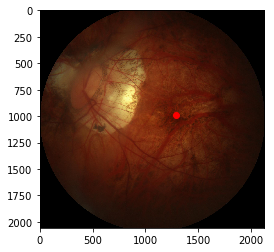

In [10]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

path = 'PLAM/PALM-Testing400-Images'
flrs = np.array(pd.read_csv('Fovea_Localization_Results.csv'))
for flr in flrs:
    img = np.array(Image.open(os.path.join(path, flr[0])))
    x, y = flr[1:]
    plt.imshow(img.astype('uint8'))
    plt.plot(x, y, 'or')
    plt.show()
    break

# 总结
1. 数据要选择一个合适的标准进行处理，两种图片大小1440和2124，如果缩放的太小或者太大都会导致其中一个效果不好，上个版本我尝试了大尺寸的图片，由于尺寸太大，网络模型太大，导致训练特别慢，这次改用小尺寸换用更多轮次看看效果如何。
2. 网络选取要合理QAQ，我这个应该就很不合理
3. 通过近几个版本的尝试，还是采用了resnet50,然后使用256的分辨率最为合适，太大了并没有降低误差反而得分很低。
4. 记得去进行排序，本来质量就不高，再不排序，分值就更低了。
## 参考资料
眼底彩照中黄斑中央凹定位相关论文
1. [Macula segmentation and fovea localization employing image processing and heuristic based clustering for automated retinal screening](https://www.sciencedirect.com/science/article/abs/pii/S0169260717304145)
2. [A Pixel-Wise Distance Regression Approach for Joint Retinal Optic Disc and Fovea Detection](https://agaldran.github.io/pdf/od_fovea_location.pdf)
3. [飞桨常规赛：PALM眼底彩照中黄斑中央凹定位 - 5月第一名方案](https://aistudio.baidu.com/aistudio/projectdetail/1894458)
4. [常规赛：PALM眼底彩照中黄斑中央凹定位比赛Baseline](https://aistudio.baidu.com/aistudio/projectdetail/1889502)

## 个人总结
>全网同名: iterhui

>我在AI Studio上获得钻石等级，点亮9个徽章，来互关呀~

https://aistudio.baidu.com/aistudio/personalcenter/thirdview/643467